# Multi-agent Trajectory Planning

These examples demonstrate the use of RxInfer for trajectory planning in multi-agent situations. The animations show the inferred trajectories from probabilistic inference.
The examples shown in this notebook are based on https://github.com/biaslab/MultiAgentTrajectoryPlanning/blob/main/door.jl, modified by [Michi-Tsubaki](https://github.com/Michi-Tsubaki) to be compatible with RxInfer ver.4 syntax, and supplemented with additional explanatory comments.

For more details, please refer to https://ieeexplore.ieee.org/document/10645034.

In [1]:
using LinearAlgebra, RxInfer, Plots, LogExpFunctions

## Define utility functions

In [2]:
begin
    
	ReactiveMP.constrain_form(pmconstraint::RxInfer.PointMassFormConstraint, distribution::MultivariateNormalDistributionsFamily) = mean(distribution) 

	ReactiveMP.prod(::GenericProd, left::Distribution, right::PointMass{Float64}) = right

	softmin(x; l=10) = -logsumexp(-l .* x)/l	

	struct Rectangle
		center
		height
		width
	end

	function distance(r::Rectangle, x) 
		if abs(x[1] - r.center[1]) > r.width/2 || abs(x[2] - r.center[2]) > r.height/2
			# outside of rectangle
			dx = max(abs(x[1] - r.center[1]) - r.width / 2, 0);
			dy = max(abs(x[2] - r.center[2]) - r.height / 2, 0)
			return sqrt(dx^2 + dy^2)
		else
			# inside rectangle
			return max(abs(x[1] - r.center[1]) - r.width/2, abs(x[2] - r.center[2]) - r.height/2)
		end
	end

	distance(env::Tuple, x) = softmin([distance(item, x) for item in env])
	
	function draw_circle!(center, radius; kwargs...)
		θ = range(0, 2π, 100)
		plot!(center[1] .+ radius .* cos.(θ), center[2] .+ radius .* sin.(θ); kwargs...)
	end

	function draw_rectangle!(r::Rectangle; kwargs...)
		plot!(Shape(r.center[1] .+ r.width/2*[-1,1,1,-1], r.center[2] .+ r.height/2 * [-1,-1, 1, 1]); kwargs...)
	end

end;

## Problem sketch

   This problem involves four agents navigating through a "door" - a narrow passage between two walls without colliding with each other.
In this scenario, the challenges include:

- **Spatial constraints:** Agents must pass through a limited space (the doorway)
- **Collision avoidance:** The four agents must avoid colliding with each other
- **Wall avoidance: Agents** must not hit the walls on either side
- **Efficient pathfinding:** Each agent should reach its destination as efficiently as possible

Using probabilistic inference, this approach represents each agent's movement as a probability distribution and infers optimal trajectories while considering the positions of other agents. The concept of halfspaces is used to probabilistically represent constraints like "don't go beyond the wall."

In this simulation, RxInfer uses Bayesian inference to calculate trajectories for each agent, with the results displayed as animations in the section below.

In [3]:
begin
	goals = hcat([
		# agent 1: start at (5,-15) with 0 velocity, end at (-5,15) with 0 velocity
		[
			[5, 0, -15, 0],
			[-5, 0, 15, 0]
		], 
		# agent 2: start at (-5,-15) with 0 velocity, end at (5,15) with 0 velocity
		[
			[-5, 0, -15, 0],
			[5, 0, 15, 0]
		],
		# agent 3: start at (-5,15) with 0 velocity, end at (5,-15) with 0 velocity
		[
			[-5, 0, 15, 0],
			[5, 0, -15, 0]
		],
		# agent 4: start at (5,15) with 0 velocity, end at (-5,-15) with 0 velocity
		[
			[5, 0, 15, 0],
			[-5, 0, -15, 0]
		]
	]...)
	radius = 2.5
	environment = (
		Rectangle([-40, 0], 5, 70),
		Rectangle([40, 0], 5, 70)
	)
end;


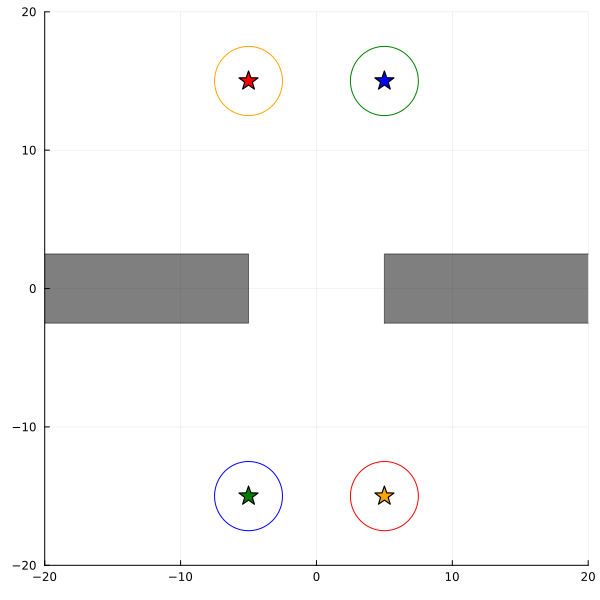

In [4]:
begin
	plot(size = (600, 600))

	scatter!([goals[2,1][1]], [goals[2,1][3]], color="red", label="", marker=:star5, markersize=10)
	scatter!([goals[2,2][1]], [goals[2,2][3]], color="blue", label="", marker=:star5, markersize=10)
	scatter!([goals[2,3][1]], [goals[2,3][3]], color="orange", label="", marker=:star5, markersize=10)
	scatter!([goals[2,4][1]], [goals[2,4][3]], color="green", label="", marker=:star5, markersize=10)
	
	draw_circle!([goals[1,1][1], goals[1,1][3]], radius; color="red", label="")
	draw_circle!([goals[1,2][1], goals[1,2][3]], radius; color="blue", label="")
	draw_circle!([goals[1,3][1], goals[1,3][3]], radius; color="orange", label="")
	draw_circle!([goals[1,4][1], goals[1,4][3]], radius; color="green", label="")

	draw_rectangle!(environment[1]; label="", color="black", alpha=0.5)
	draw_rectangle!(environment[2]; label="", color="black", alpha=0.5)

	xlims!(-20, 20)
	ylims!(-20, 20)
end

## Halfspace prior implementation

In [5]:
# Define the probabilistic model for obstacles using halfspace constraints
begin

	# node specification
	struct Halfspace end
	@node Halfspace Stochastic [out, a, σ2, γ]

	# rule specification
	@rule Halfspace(:out, Marginalisation) (q_a::PointMass, q_σ2::PointMass, q_γ::PointMass) = begin
		return NormalMeanVariance(mean(q_a) + mean(q_γ) * mean(q_σ2), mean(q_σ2))
	end

	@rule Halfspace(:σ2, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_a::PointMass, q_γ::PointMass, ) = begin
		return PointMass( 1 / mean(q_γ) * sqrt(abs2(mean(q_out) - mean(q_a)) + var(q_out)))
	end
	
end

## Model specification

In [6]:
function g(y; r = radius)
	return distance(environment, y) - r
end;

In [7]:
function h(y1, y2, y3, y4; r = radius)
	return softmin([
		norm(y1 - y2) - 2*r,
		norm(y1 - y3) - 2*r,
		norm(y1 - y4) - 2*r,
		norm(y2 - y3) - 2*r,
		norm(y2 - y4) - 2*r,
		norm(y3 - y4) - 2*r,
	])
end;

In [8]:
# Define model
@model function door_model(nr_steps, γ, A, B, C, goals)

	local y
	
	# single agent models
	for k in 1:4

		# prior on state
		x[k,1] ~ MvNormalMeanCovariance(zeros(4), 1e2I)
	
		for t in 1:nr_steps
			
			# prior on controls
			u[k,t] ~ MvNormalMeanCovariance(zeros(2), 1e-1I)
	
			# state transition
			x[k,t+1] ~ A * x[k,t] + B * u[k,t]
	
			# observation model
			y[k,t] ~ C * x[k,t+1]

			# environmental distance
			zσ2[k,t] ~ GammaShapeRate(3/2, γ^2/2)
			z[k,t] ~ g(y[k,t])
			z[k,t] ~ Halfspace(0, zσ2[k,t], γ)

		end

		# goal priors (indexing reverse due to definition)
		goals[1,k] ~ MvNormalMeanCovariance(x[k,1], 1e-5I)
		goals[2,k] ~ MvNormalMeanCovariance(x[k,nr_steps + 1], 1e-5I)
		
	end

	for t = 1:nr_steps

		# observation constraint
		dσ2[t] ~ GammaShapeRate(3/2, γ^2/2)
		d[t] ~ h(y[1,t], y[2,t], y[3,t], y[4,t])
		d[t] ~ Halfspace(0, dσ2[t], γ)
		
	end
	
end;

## Constraint specification

In [9]:
@constraints function door_constraints()
	q(d, dσ2) = q(d)q(dσ2)
	q(z, zσ2) = q(z)q(zσ2)
end;

## Probabilistic inference
### Settings

In [10]:
# Define meta model
door_meta = @meta begin 
    h() -> Linearization(),
	g() -> Linearization()
end;

In [11]:
nr_steps = 50

50

In [12]:
nr_iterations = 1500

1500

In [13]:
# Define constant variables
begin
	ΔT = 1
	A = [1 ΔT 0 0; 
		0 1 0 0; 
		0 0 1 ΔT; 
		0 0 0 1]
	B = [0 0; 
		ΔT 0; 
		0 0; 
		0 ΔT]
	C = [1 0 0 0; 
		0 0 1 0]
	γ = 1
end;

In [14]:
# Initialize variables
init = @initialization begin

    q(dσ2) = repeat([PointMass(1)], nr_steps)
    q(zσ2) = repeat([PointMass(1)], 4, nr_steps)
    q(u) = repeat([PointMass(0)], nr_steps)

	μ(x) = MvNormalMeanCovariance(randn(4), 100I)
	μ(y) = MvNormalMeanCovariance(randn(2), 100I)

end

Initial state: 
  q(dσ2) = PointMass{Int64}[PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1)  …  PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1)]
  q(zσ2) = PointMass{Int64}[PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1); PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1); PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1); PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1)]
  q(u) = PointMass{Int64}[PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), 

> **Note:** In RxInfer version 2, constants were specified using constvar or as keyword arguments in model functions, but in RxInfer versions 3 and 4, they are specified as arguments outside the function.
Also, in RxInfer version 2, variables were initialized inside the inference function, but now we use the initialization macro instead.

### Inference

In [15]:
results = infer(
	model 			= door_model(nr_steps = nr_steps, γ = γ, A = A, B = B, C = C),
	data  			= ( goals = goals, ),
	initialization  = init,
	constraints 	= door_constraints(),
	meta 			= door_meta,
	iterations 		= nr_iterations,
	returnvars 		= KeepLast(), 
	options = ( limit_stack_depth = 300, )
)

Inference results:
  Posteriors       | available for (d, y, zσ2, z, dσ2, u, x)


> **Note:** The syntax of this infer function (function name and initialization method) differs between RxInfer version 2 and 4. See http://docs.rxinfer.ml/stable/manuals/migration-guide-v2-v3/ .

## Results

This section shows the results of inference.

In [16]:
animation = @animate for t in 1:nr_steps
	plot(size = (0.8*600, 600), legend=false)

	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][1,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][1,1:t]);
		color="red", linestyle=:dash
	)
	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][2,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][2,1:t]);
		color="blue", linestyle=:dash
	)
	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][3,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][3,1:t]);
		color="orange", linestyle=:dash
	)
	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][4,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][4,1:t]);
		color="green", linestyle=:dash
	)

	draw_circle!(mean(results.posteriors[:y][1,t]), radius; color="red", label="")
	draw_circle!(mean(results.posteriors[:y][2,t]), radius; color="blue", label="")
	draw_circle!(mean(results.posteriors[:y][3,t]), radius; color="orange", label="")
	draw_circle!(mean(results.posteriors[:y][4,t]), radius; color="green", label="")

	draw_rectangle!(environment[1]; label="", color="black", alpha=0.5)
	draw_rectangle!(environment[2]; label="", color="black", alpha=0.5)

	scatter!([goals[2,1][1]], [goals[2,1][3]], color="red", label="", marker=:star5, markersize=10)
	scatter!([goals[2,2][1]], [goals[2,2][3]], color="blue", label="", marker=:star5, markersize=10)
	scatter!([goals[2,3][1]], [goals[2,3][3]], color="orange", label="", marker=:star5, markersize=10)
	scatter!([goals[2,4][1]], [goals[2,4][3]], color="green", label="", marker=:star5, markersize=10)
	
	xlims!(-20, 20)
	ylims!(-25, 25)
		
end

# assign the path to save the image
gif(animation, "result.gif", fps = 15);

┌ Info: Saved animation to /Users/bvdmitri/.julia/dev/RxInferExamples.jl/examples/Advanced Examples/Multi-agent Trajectory Planning/result.gif
└ @ Plots /Users/bvdmitri/.julia/packages/Plots/Ec1L1/src/animation.jl:156


![](result.gif)